Predicting species

Setup

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch.nn import (
    ReLU, 
    Conv2d, 
    Module, 
    Sequential, 
    MaxPool2d, 
    Flatten, 
    AdaptiveAvgPool2d, 
    Linear, 
    CrossEntropyLoss,
)
from torch.nn.functional import log_softmax
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose, 
    TrivialAugmentWide, 
    ToImage, 
    ToDtype, 
    Normalize, 
    Resize,
    CenterCrop,
    RandomRotation,
    RandomResizedCrop,
)
from torchvision.models import resnet18

from nn_training import train_and_eval, select_device

from plotting import setup_high_quality_mpl_params


def plot_loss_curves(epochs:list, train_losses:list, eval_losses:list, ax):
    ax.plot(epochs, train_losses, label="Training Loss")
    ax.plot(epochs, eval_losses, label="Eval. Loss")
    ax.legend()
    ax.set_xlabel("Epoch")


def split_train_val(df_img_catalog, val_proportion:float):
    rng = np.random.default_rng()
    val_indices = rng.choice(len(df_img_catalog), size=int(len(df_img_catalog)*val_proportion), replace=False)
    df_val = df_img_catalog.iloc[np.isin(df_img_catalog.index, val_indices)]
    df_train = df_img_catalog.iloc[np.isin(df_img_catalog.index, val_indices, invert=True)]
    return df_train, df_val


def aggregate_images(df_img_catalog, img_dir_path):
    img_dir_path = Path(img_dir_path)
    img_paths = [img_dir_path.joinpath(i) for i in df_img_catalog["filename"]]
    pil_imgs = [Image.open(i) for i in img_paths]
    to_torch_img = ToImage()
    tensor_imgs = [to_torch_img(i) for i in pil_imgs]
    expanded_tensor_imgs = [torch.unsqueeze(i, dim=0) for i in tensor_imgs]
    aggregated_imgs = torch.cat(expanded_tensor_imgs)
    return aggregated_imgs


def predict_logits(dataset, model):

    imgs = dataset.tensor_imgs
    imgs = dataset.transform(imgs)

    model.eval()
    with torch.no_grad():
        logits = model(imgs)

    return logits


def predict_set_log_probs(dataset, model, n):
    """n : number of (augmented) copies of each example in the set"""
    logits = torch.cat([torch.unsqueeze(predict_logits(dataset, model), 0) for _ in range(n)])
    log_probs = torch.log_softmax(logits, dim=2)
    return log_probs


def predict_classes(logits):
    """
    logits : thing over which to take argmax
    """
    preds = logits.argmax(axis=1)
    return preds


def calculate_accuracy(preds, labels):
    assert preds.shape == labels.shape
    matches = (preds == labels)
    _, counts = torch.unique(matches, return_counts=True)
    n_wrong = counts[0]
    n_right = counts[1]
    acc = n_right / (n_right + n_wrong)
    return acc


def calculate_log_prior(dataset):
    n_classes = 54
    classes = torch.arange(n_classes)
    counts = torch.zeros(len(classes))
    for c in classes:
        counts[c] = torch.count_nonzero(dataset.tensor_img_labels == c) + 1  # fudge term 
    prob_prior = counts / torch.sum(counts)
    log_prob_prior = torch.log(prob_prior)
    return log_prob_prior


def predict_set_log_prob_bayes(dataset, model, log_prior, n):
    """Off by a constant"""
    log_probs = predict_set_log_probs(dataset, model, n)
    sum_log_probs = torch.sum(log_probs, dim=0)
    sum_log_priors = (n-1)*log_prior
    log_prob_bayes = sum_log_probs - sum_log_priors
    return log_prob_bayes


def make_test_submission(class_preds, test_dataset, model):
    df_test_catalog = pd.read_csv(test_dataset.img_catalog_file_paths["test"])
    assert len(class_preds) == len(df_test_catalog["id"])
    df_submission = pd.DataFrame({"id": df_test_catalog["id"], "predictions":class_preds.cpu()})
    save_file_path = Path(f"submission_{model.nickname}.csv")
    df_submission.to_csv(save_file_path, index=False)
    return
    

class Image_Dataset(Dataset):
    
    def __init__(self):
        
        self.img_catalog_file_paths = {
            "original_train": Path("train_catalog.csv"),
            "train": Path("train_catalog_train.csv"),
            "val": Path("train_catalog_val.csv"),
            "test": Path("test_catalog.csv"),
        }

        self.img_dir_paths = {
            "train":Path("train/train"),
            "test":Path("test/test"),
        }

        self.tensor_imgs_file_paths = {
            "train": Path("train_imgs_train.pt"),
            "val": Path("train_imgs_val.pt"),
            "test": Path("test_imgs.pt"),
        }

        self.image_net_norm = {
            "mean": [0.485, 0.456, 0.406,], 
            "std": [0.229, 0.224, 0.225],
        }

    def generate(self, validation_split_proportion,):
        df_img_catalog_original_train = pd.read_csv(self.img_catalog_file_paths["original_train"]).drop(columns="id")
        df_img_catalog_train, df_img_catalog_val = split_train_val(df_img_catalog_original_train, validation_split_proportion)
        df_img_catalog_train.to_csv(self.img_catalog_file_paths["train"], index=False)
        df_img_catalog_val.to_csv(self.img_catalog_file_paths["val"], index=False)

        tensor_imgs_train = aggregate_images(df_img_catalog_train, self.img_dir_paths["train"])
        torch.save(tensor_imgs_train, self.tensor_imgs_file_paths["train"])
        tensor_imgs_val = aggregate_images(df_img_catalog_val, self.img_dir_paths["train"])
        torch.save(tensor_imgs_val, self.tensor_imgs_file_paths["val"])
        tensor_imgs_test = aggregate_images(pd.read_csv(self.img_catalog_file_paths["test"]), self.img_dir_paths["test"])
        torch.save(tensor_imgs_test, self.tensor_imgs_file_paths["test"])

    def load(self, split, device, augmentation=None):
        self.split = split
        
        assert split in {"train", "val", "test"}
        if split == "test":
            self.tensor_imgs = torch.load(self.tensor_imgs_file_paths["test"], weights_only=True).to(device)
        elif split in {"train", "val"}:
            self.tensor_imgs = torch.load(self.tensor_imgs_file_paths[split], weights_only=True).to(device)
            self.tensor_img_labels = torch.from_numpy(pd.read_csv(self.img_catalog_file_paths[split])["label"].to_numpy()).to(device)
            assert len(self.tensor_imgs) == len(self.tensor_img_labels)
        else: raise ValueError

        assert augmentation in {None, "trivial", "chefschoice"}
        if augmentation is None:
            self.set_no_augmentation()
        elif augmentation == "trivial":
            self.set_trivial_augmentation()
        elif augmentation == "chefschoice":
            self.set_chefs_choice_augmentation()
        else: raise ValueError
    
    def set_no_augmentation(self):
        self.transform = Compose([
            ToDtype(torch.uint8, scale=True),
            Resize(size=256),
            CenterCrop(size=[224]),
            ToDtype(torch.float32, scale=True),
            Normalize(mean=self.image_net_norm["mean"], std=self.image_net_norm["std"]),
        ])

    def set_trivial_augmentation(self):
        self.transform = Compose([
            ToDtype(torch.uint8, scale=True),
            Resize(size=256),
            CenterCrop(size=[224]),
            TrivialAugmentWide(),
            ToDtype(torch.float32, scale=True),
            Normalize(mean=self.image_net_norm["mean"], std=self.image_net_norm["std"]),
        ])

    def set_chefs_choice_augmentation(self):
        self.transform = Compose([
            ToDtype(torch.uint8, scale=True),
            Resize(size=256),
            CenterCrop(size=[224]),
            # RandomRotation(180, fill=(61,57,56)),
            # RandomResizedCrop(),
            ToDtype(torch.float32, scale=True),
            Normalize(mean=self.image_net_norm["mean"], std=self.image_net_norm["std"]),
        ])

    def __len__(self):
        return len(self.tensor_imgs)
    
    def __getitem__(self, index):
        if self.split == "test":
            x = self.tensor_imgs[index]
            x = self.transform(x)
            return x
        elif self.split in {"train", "val"}:
            x = self.tensor_imgs[index]
            x = self.transform(x)
            y = self.tensor_img_labels[index]
            return x, y 


class Simple_CNN(Module):

    def __init__(self, n_image_channels, n_classes, nickname):
        super().__init__()
        self.nickname = nickname
        self.save_file_path = Path(nickname+".pt")

        self.conv = Sequential(
            Conv2d(in_channels=n_image_channels, out_channels=16, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            ReLU(),
            AdaptiveAvgPool2d(1),            
        )

        self.dense = Sequential(
            Linear(in_features=128, out_features=128),
            ReLU(),
            Linear(in_features=128, out_features=64),
            ReLU(),
            Linear(in_features=64, out_features=n_classes),
        )

    def forward(self, x):
        z = self.conv(x)
        z = z.squeeze()
        result = self.dense(z)
        return result
    

class Image_Net_Transfer_Model(Module):

    def __init__(self, n_classes, base_model, nickname):
        super().__init__()
        self.nickname = nickname
        self.save_file_path = Path(nickname+".pt")

        self.model = base_model(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        result = self.model(x)
        return result
    

setup_high_quality_mpl_params()
device = select_device()

Device:  cuda


Generate Data

In [ ]:
Image_Dataset().generate(validation_split_proportion=0.25)

Try a simple CNN without image augmentation

In [ ]:
retrain = False

dset_train = Image_Dataset()
dset_train.load("train", device)
dset_val = Image_Dataset()
dset_val.load("val", device)
dset_test = Image_Dataset()
dset_test.load("test", device)

model = Simple_CNN(n_image_channels=3, n_classes=54, nickname="simple_cnn")

if retrain:
    learning_rate = 3e-4
    epochs = 100
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

logits_val = predict_logits(dset_val, model)
class_preds_val = predict_classes(logits_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

make_test_submission(dset_test, model)



Try a simple CNN with image augmentation (trivial)

In [ ]:
retrain = False

dset_train = Image_Dataset()
dset_train.load("train", device, augmentation="trivial")
dset_val = Image_Dataset()
dset_val.load("val", device, augmentation=None)
dset_test = Image_Dataset()
dset_test.load("test", device, augmentation=None)

model = Simple_CNN(n_image_channels=3, n_classes=54, nickname="simple_cnn_ta")

if retrain:
    learning_rate = 3e-4
    epochs = 100
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

logits_val = predict_logits(dset_val, model)
class_preds_val = predict_classes(logits_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

make_test_submission(dset_test, model)

Try a transfer learning model without augmentation (Vanilla Transfer Learning Approach)

In [ ]:
retrain = True

dset_train = Image_Dataset()
dset_train.load("train", device)
dset_val = Image_Dataset()
dset_val.load("val", device)
dset_test = Image_Dataset()
dset_test.load("test", device)

model = Image_Net_Transfer_Model(n_classes=54, base_model=resnet18, nickname="transfer_res18")

if retrain:
    learning_rate = 3e-4
    epochs = 30
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

logits_val = predict_logits(dset_val, model)
class_preds_val = predict_classes(logits_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

# make_test_submission(dset_test, model)


Try a transfer learning model with augmentation (trivial)

In [ ]:
retrain = False

dset_train = Image_Dataset()
dset_train.load("train", device, augmentation="trivial")
dset_val = Image_Dataset()
dset_val.load("val", device, augmentation=None)
dset_test = Image_Dataset()
dset_test.load("test", device, augmentation=None)

model = Image_Net_Transfer_Model(n_classes=54, base_model=resnet18, nickname="transfer_res18_ta")

if retrain:
    learning_rate = 3e-4
    epochs = 30
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

logits_val = predict_logits(dset_val, model)
class_preds_val = predict_classes(logits_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

make_test_submission(dset_test, model)


Try a transfer learning model with augmentation (rotate only)

In [ ]:
retrain = False

dset_train = Image_Dataset()
dset_train.load("train", device, augmentation="chefschoice")
dset_val = Image_Dataset()
dset_val.load("val", device)
dset_test = Image_Dataset()
dset_test.load("test", device)

model = Image_Net_Transfer_Model(n_classes=54, base_model=resnet18, nickname="transfer_res18_cc")

if retrain:
    learning_rate = 3e-4
    epochs = 100
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

logits_val = predict_logits(dset_val, model)
class_preds_val = predict_classes(logits_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

make_test_submission(dset_test, model)


Try putting the augmentations at the end (naive bayes with prior) (Augmented Set Approach)

c:\Users\tetha\miniforge3\envs\maybe_ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tetha\miniforge3\envs\maybe_ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



epoch 0 complete:
    Train loss: 2.2470510005950928
    Eval loss: 1.8409180641174316

peak gpu memory usage: 1.99576 GB

epoch 1 complete:
    Train loss: 1.7266443967819214
    Eval loss: 1.56444251537323

peak gpu memory usage: 1.99576 GB

epoch 2 complete:
    Train loss: 1.516083836555481
    Eval loss: 1.4267733097076416

peak gpu memory usage: 1.99576 GB

epoch 3 complete:
    Train loss: 1.4004329442977905
    Eval loss: 1.3389923572540283

peak gpu memory usage: 1.99576 GB

epoch 4 complete:
    Train loss: 1.3154958486557007
    Eval loss: 1.263880729675293

peak gpu memory usage: 1.99576 GB

epoch 5 complete:
    Train loss: 1.261745572090149
    Eval loss: 1.2172397375106812

peak gpu memory usage: 1.99576 GB

epoch 6 complete:
    Train loss: 1.2053563594818115
    Eval loss: 1.1796457767486572

peak gpu memory usage: 1.99576 GB

epoch 7 complete:
    Train loss: 1.1747795343399048
    Eval loss: 1.156506896018982

peak gpu memory usage: 1.99576 GB

epoch 8 complete:
   

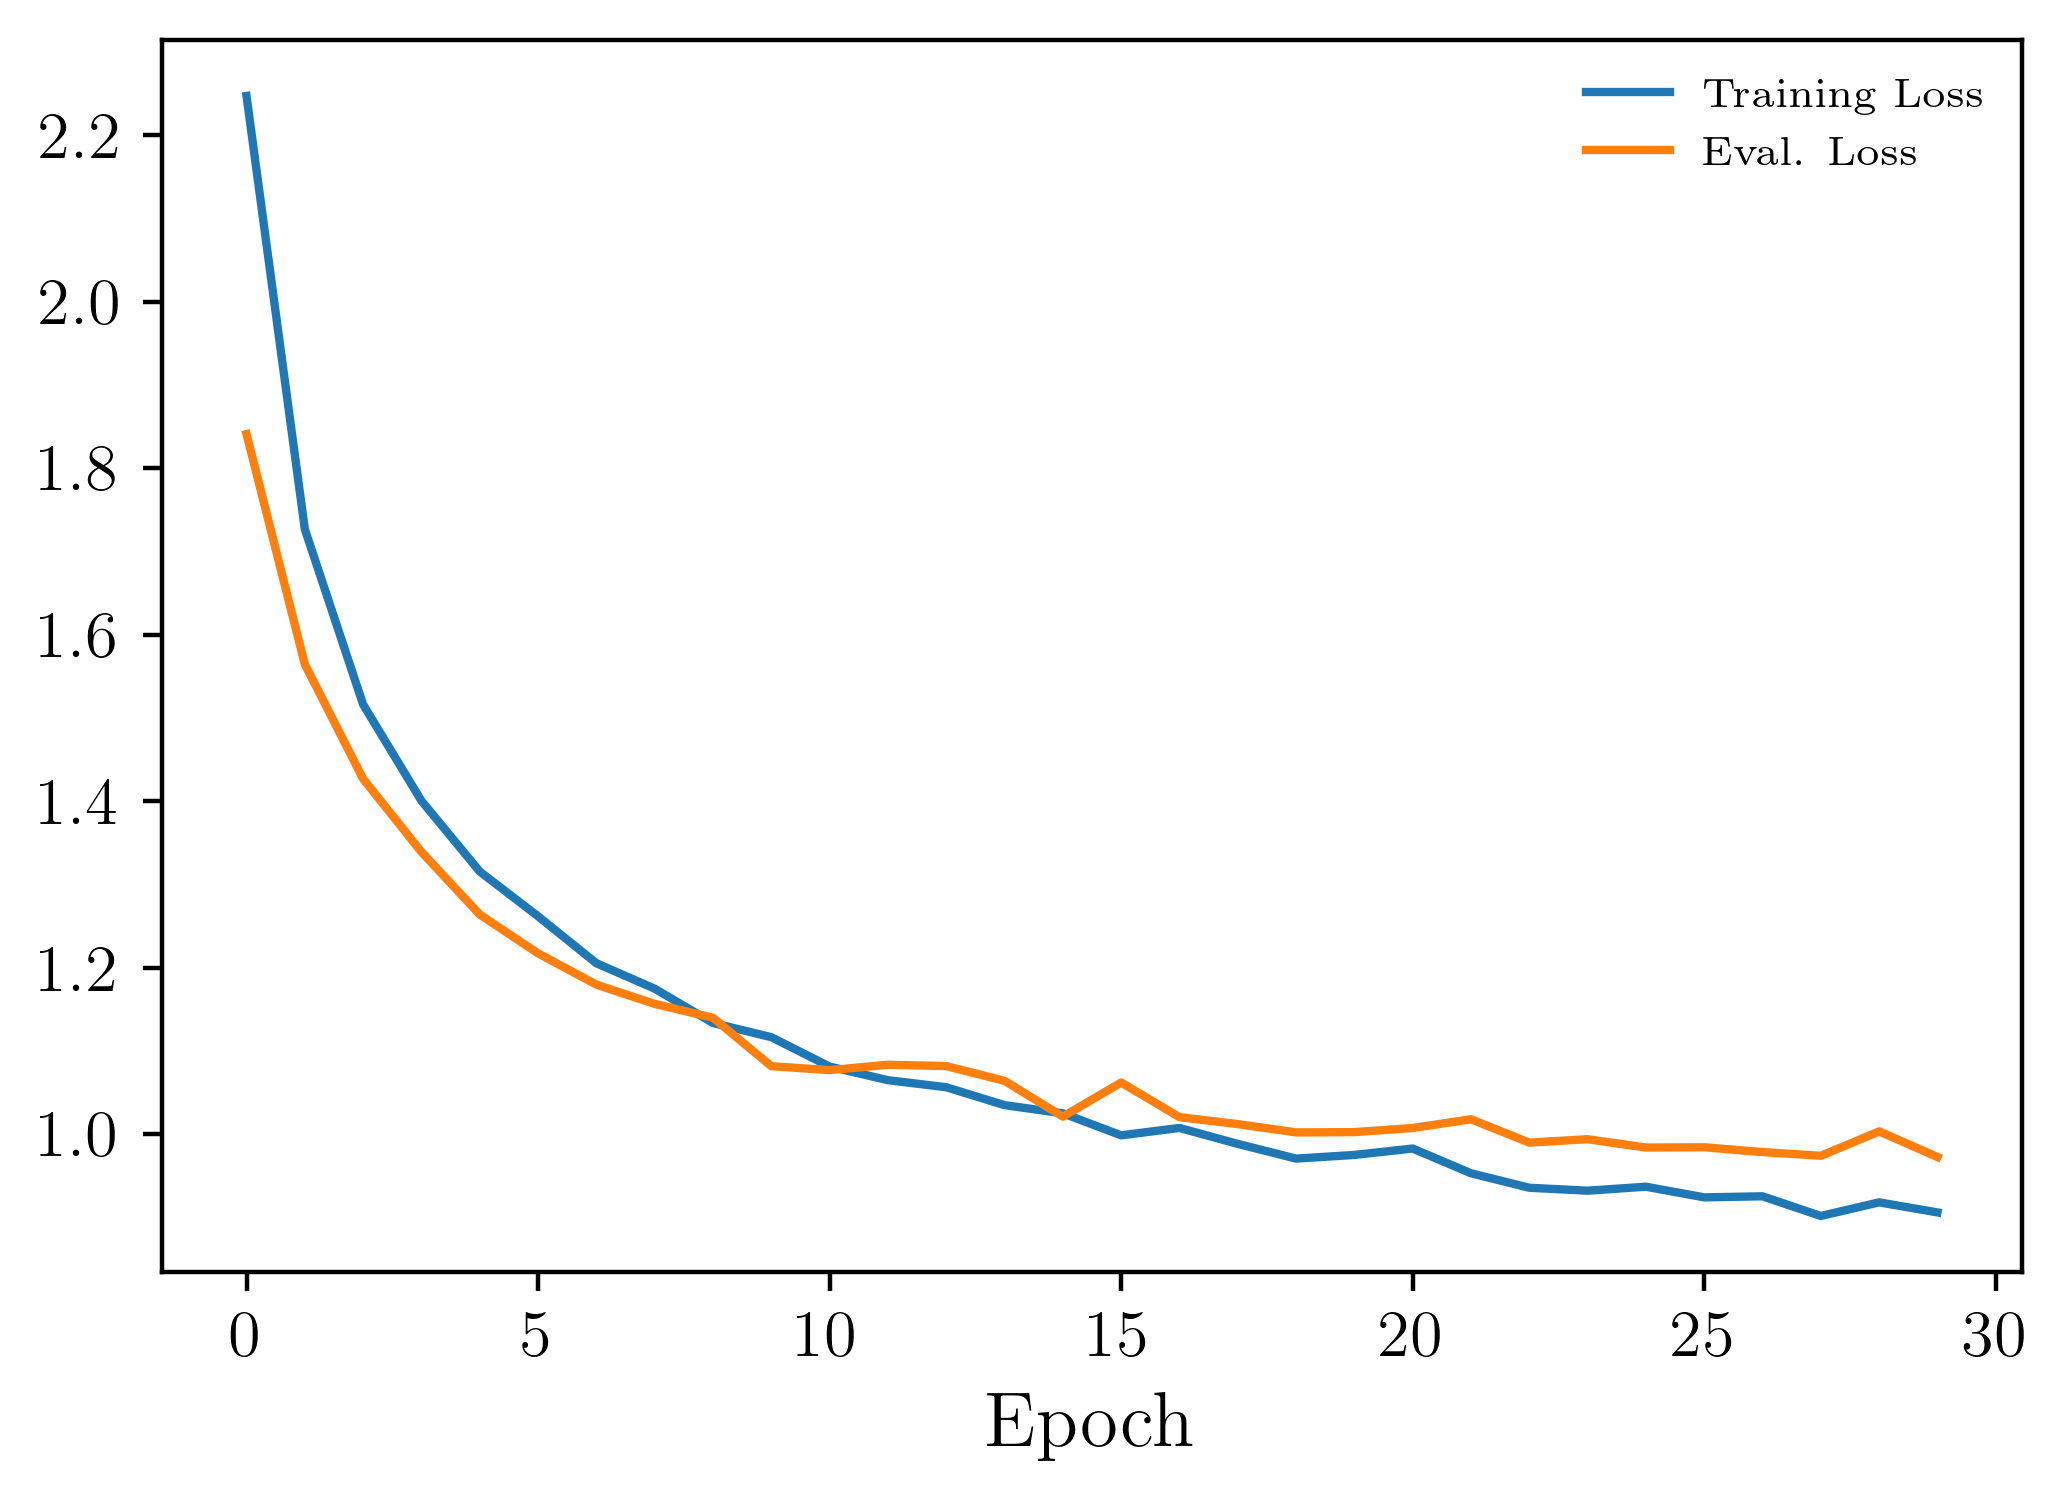

In [2]:
retrain = True

dset_train = Image_Dataset()
dset_train.load("train", device, augmentation="trivial")
dset_val = Image_Dataset()
dset_val.load("val", device, augmentation="trivial")
dset_test = Image_Dataset()
dset_test.load("test", device, augmentation="trivial")

model = Image_Net_Transfer_Model(n_classes=54, base_model=resnet18, nickname="transfer_res18_bayes")

if retrain:
    learning_rate = 3e-4
    epochs = 30
    train_batch_size = 64
    eval_batch_size = 64
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_table = train_and_eval(
        model, 
        dset_train, 
        dset_val, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, 
        eval_batch_size, 
        device, 
        move_data=False
    )
    torch.save(model.state_dict(), model.save_file_path)
    fig, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
else:
    model.load_state_dict(torch.load(model.save_file_path, weights_only=True))
    model.to(device)

log_prior_train = calculate_log_prior(dset_train).to(device)
num_copies = 10
log_probs = predict_set_log_probs(dset_val, model, num_copies)
log_prob_bayes_val = predict_set_log_prob_bayes(dset_val, model, log_prior_train, num_copies)
class_preds_val = predict_classes(log_prob_bayes_val)
val_accuracy = calculate_accuracy(class_preds_val, dset_val.tensor_img_labels)
print("validaton accuracy: ", val_accuracy)

# log_prior_train = calculate_log_prior(dset_train).to(device)
# num_copies = 10
# log_prob_bayes_test = predict_set_log_prob_bayes(dset_test, model, log_prior_train, num_copies)
# class_preds_test = predict_classes(log_prob_bayes_test)
# make_test_submission(class_preds_test, dset_test, model)


Plot Sum of Log Probabilities

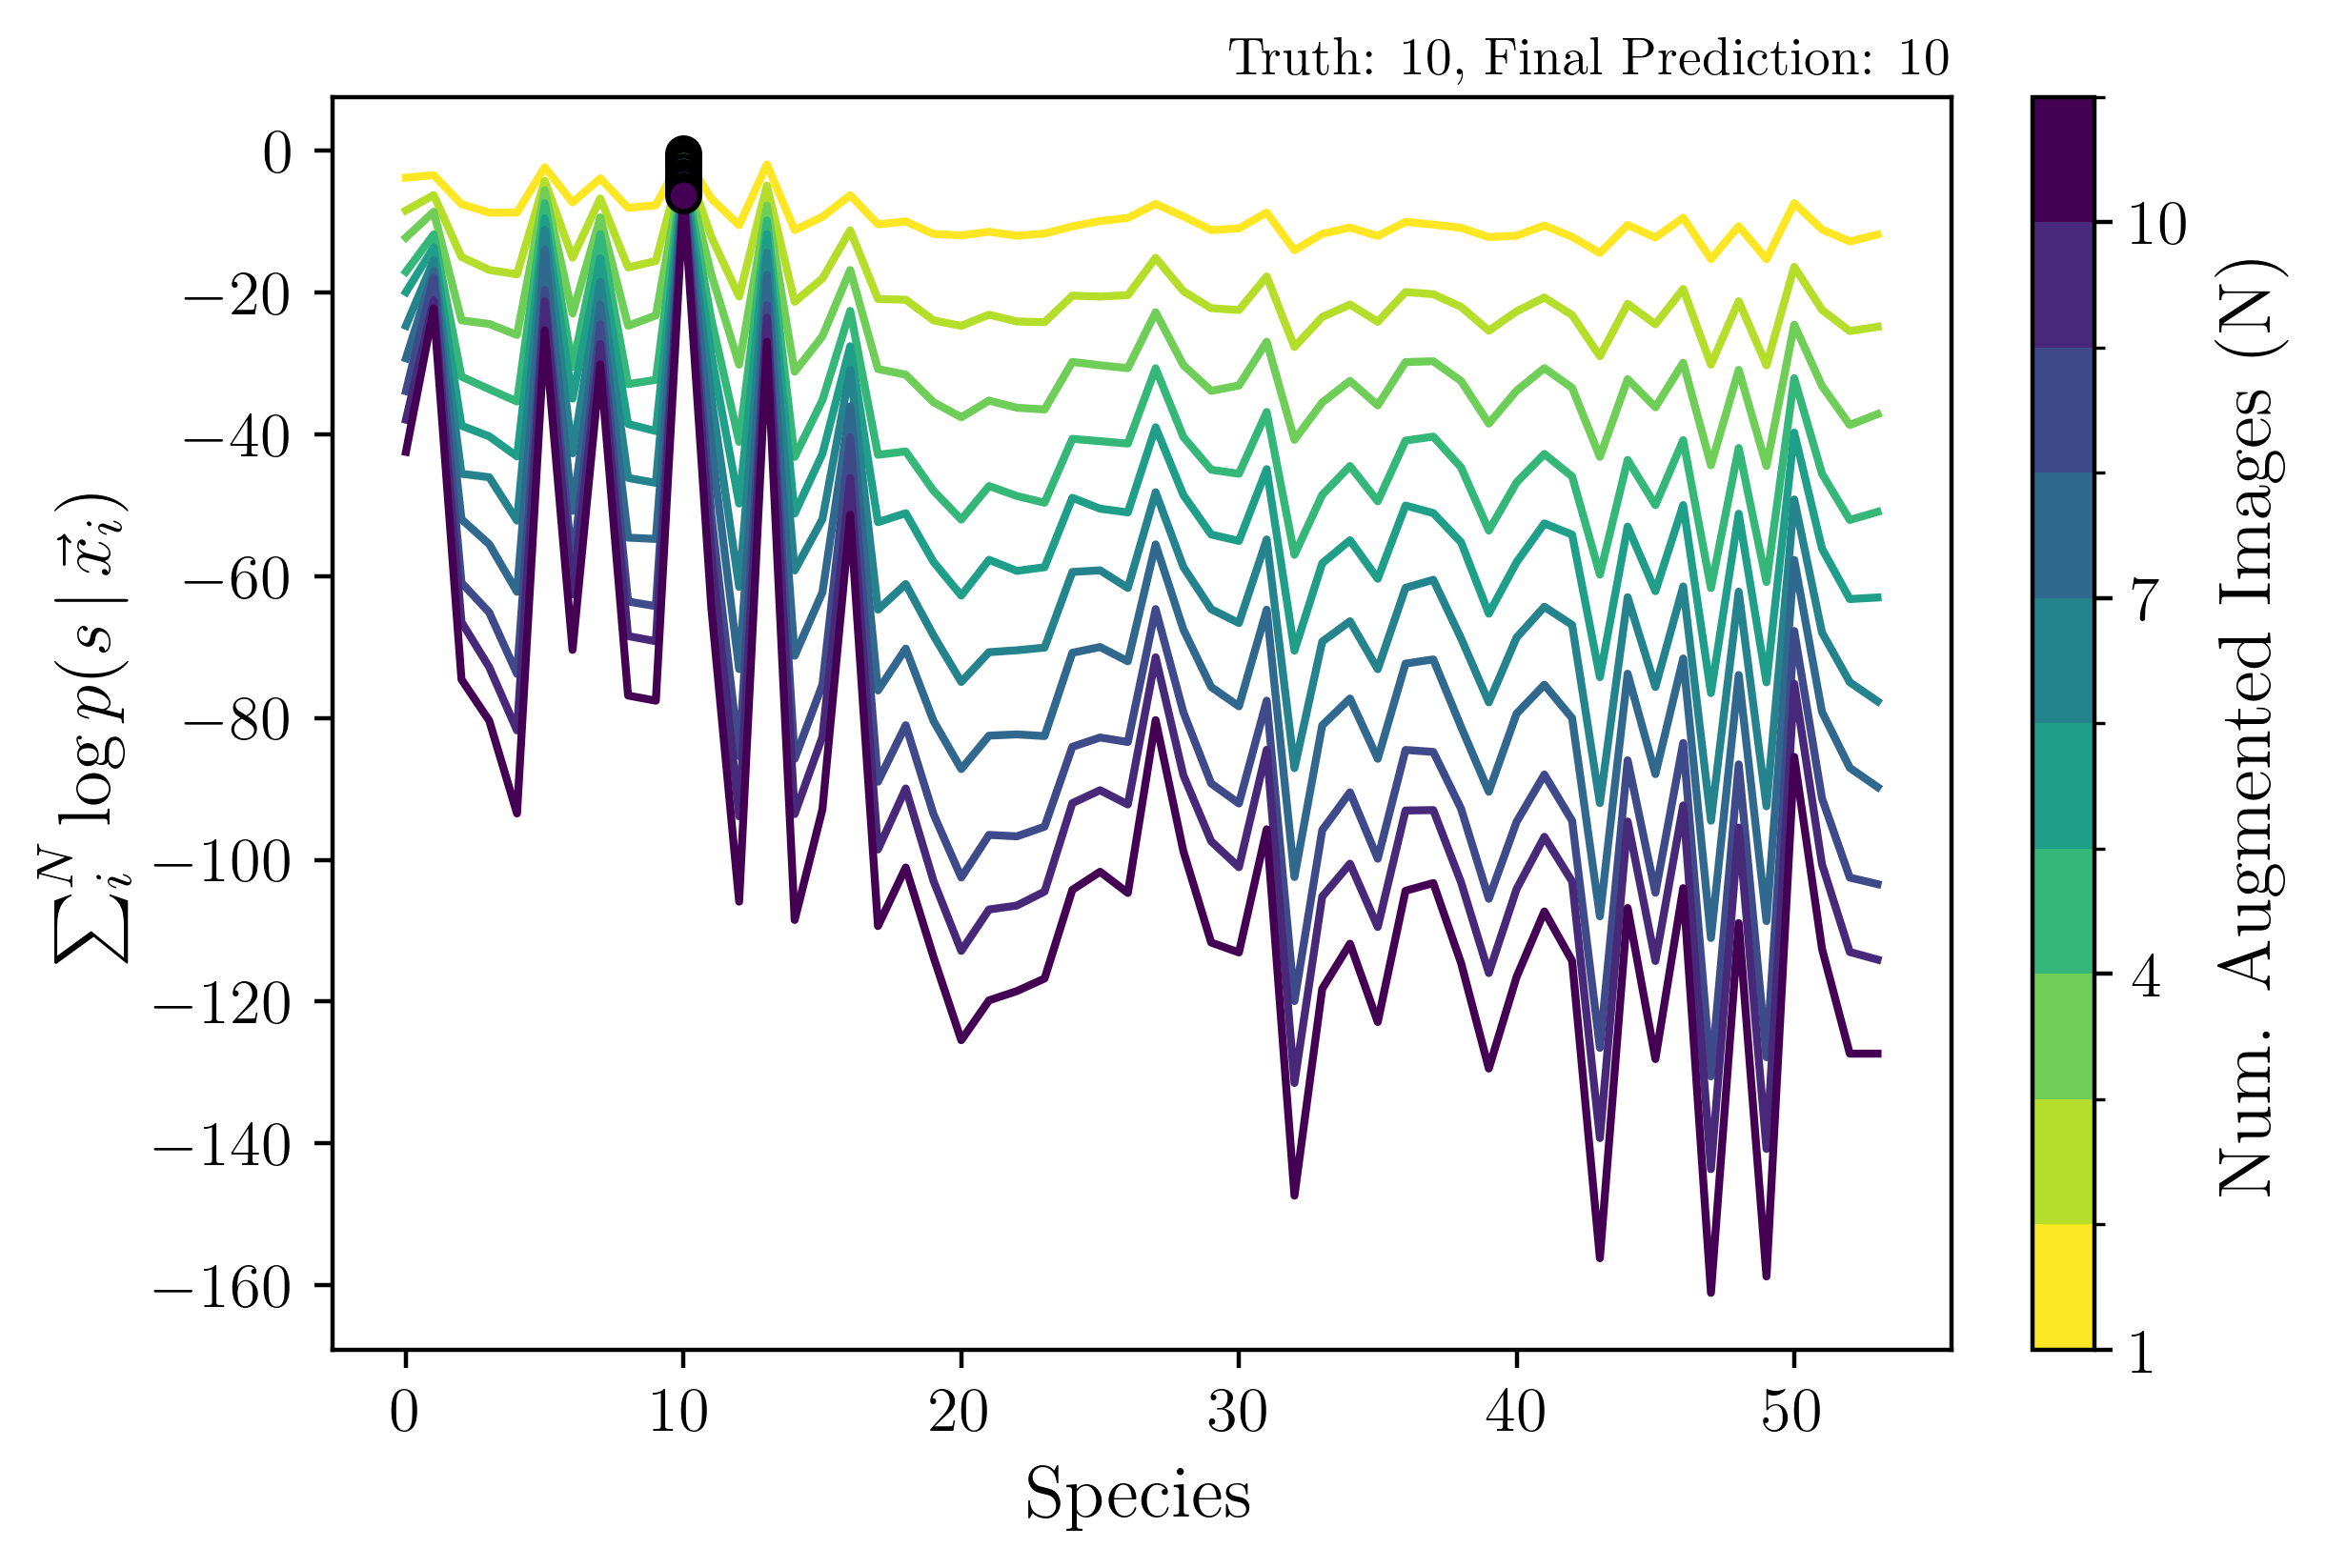

In [3]:
max_num_copies = 10
img_label = 10
sub_index = 3

fig, ax = plt.subplots(layout="constrained")

cmap = mpl.colormaps["viridis_r"]

bounds = range(1, max_num_copies+2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for n_copies in range(1,11):
    sum_log_probs = torch.sum(log_probs[:n_copies], dim=0)
    sum_log_prob_img = sum_log_probs[dset_val.tensor_img_labels == img_label][sub_index]
    plt.plot(sum_log_prob_img.cpu(), color=cmap(norm(n_copies)))
    plt.scatter(torch.argmax(sum_log_prob_img).cpu(), torch.max(sum_log_prob_img).cpu(), color=cmap(norm(n_copies)), edgecolors="black", zorder=100)
final_pred = torch.argmax(sum_log_prob_img)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r"Num. Augmented Images (N)", ticks=range(1,11, 3))
ax.set_xlabel(r"Species")
ax.set_ylabel(r"$\sum_i^N \log p(s \,|\, \vec{x}_i)$")
ax.text(
    1, 1.01, 
    f"Truth: {img_label}, Final Prediction: {final_pred.cpu()}", 
    horizontalalignment="right", verticalalignment="bottom", 
    transform=ax.transAxes
)

plt.show()